# NN implemetation with Keras

## Imports

In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder


## Utils functions

In [79]:
# Funzione per normalizzare i dati
def normalize(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data


In [80]:
def split_data(data, labels, k=5):
    """
    Divide i dati in k fold.
    
    Args:
        data (np.ndarray | pd.DataFrame): Dati di input.
        labels (np.ndarray | pd.Series): Etichette.
        k (int): Numero di fold.
    
    Returns:
        list: Lista di tuple (fold_data, fold_labels).
    """
    if not isinstance(data, np.ndarray):
        data = data.to_numpy()  # Converte DataFrame in NumPy array
    if not isinstance(labels, np.ndarray):
        labels = labels.to_numpy()  # Converte Series in NumPy array
    
    data = normalize(data)

    fold_size = len(data) // k
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    folds = []

    for i in range(k):
        fold_indices = indices[i * fold_size: (i + 1) * fold_size]
        fold_data = data[fold_indices]
        fold_labels = labels[fold_indices]
        folds.append((fold_data, fold_labels))
    
    return folds

In [81]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    - history: History object returned by model.fit().
    - params: Dictionary containing the model parameters.
    """

    # Estrai dati dalla history
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    
    epochs = range(1, len(train_loss) + 1)  # Numero di epoche

    # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [82]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Genera tutte le combinazioni di iperparametri basate su range e step specificati.

    :param param_ranges: Dizionario con i nomi degli iperparametri come chiavi.
                         Ogni valore è una tupla (start, stop, step).
    :return: Lista di dizionari con tutte le combinazioni possibili.
    """
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    param_combinations = list(itertools.product(*param_values.values()))
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

## Model creation

In [83]:
def create_nn(input_dim, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, learning_rate=0.01,
              hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, alpha=0.01):
    """
    Create a binary classification neural network with Leaky ReLU and configurable parameters.
    
    Parameters:
    - input_dim (int): Number of input features.
    - learning_rate (float): Learning rate for the optimizer.
    - hidden_size (int): Number of nodes in each hidden layer.
    - hidden_layers (int): Number of hidden layers.
    - regularization (float): L2 regularization factor.
    - momentum (float): Momentum for the optimizer.
    - alpha (float): Negative slope coefficient for Leaky ReLU.
    
    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()
    

    # Input layer (using Input layer explicitly)
    model.add(Input(shape=(input_dim,)))  # Input layer defined explicitly

    if reg_flag & (activ_type == 'licky_relu'):
        # Hidden layers with Leaky ReLU 
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size,
                            kernel_regularizer=l2(regularization)))
            model.add(LeakyReLU(negative_slope=alpha))  # Updated to use negative_slope parameter

    elif (not reg_flag) & (activ_type == 'licky_relu'):
         # Hidden layers with Leaky ReLU 
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size))
            model.add(LeakyReLU(negative_slope=alpha))  # Updated to use negative_slope parameter

    elif reg_flag:
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type,
                         kernel_regularizer=regularizers.l2(regularization)
                        ))  # ReLU activation directly in Dense layer
    else:
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type))  # ReLU activation directly in Dense layer


    
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    if optim_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

## Data loading

In [84]:
# One-hot encoding
encoder = OneHotEncoder(categories='auto', sparse_output=False)

# Carica i file di addestramento e test per ciascun dataset dal percorso specificato
monk1_train = pd.read_csv('../Datasets/Monks/monks-1.train', sep='\s+', header=None)
monk1_test = pd.read_csv('../Datasets/Monks/monks-1.test', sep='\s+', header=None)

monk2_train = pd.read_csv('../Datasets/Monks/monks-2.train', sep='\s+', header=None)
monk2_test = pd.read_csv('../Datasets/Monks/monks-2.test', sep='\s+', header=None)

monk3_train = pd.read_csv('../Datasets/Monks/monks-3.train', sep='\s+', header=None)
monk3_test = pd.read_csv('../Datasets/Monks/monks-3.test', sep='\s+', header=None)


# Lista per memorizzare i dataset trasformati
monks_train = []
monks_test = []


# Dataset monk1
X1_train = monk1_train.iloc[:, 1:7].values  # Caratteristiche
y1_train = monk1_train.iloc[:, 0].values    # Etichette

X1_test = monk1_test.iloc[:, 1:7].values
y1_test = monk1_test.iloc[:, 0].values

# Applicazione dell'encoder a monk1
X1_train_encoded = encoder.fit_transform(X1_train)  # Fit e trasformazione sui dati di training
X1_test_encoded = encoder.transform(X1_test)        # Solo trasformazione sui dati di test

monks_train.append((X1_train_encoded, y1_train))
monks_test.append((X1_test_encoded, y1_test))

# Dataset monk2
X2_train = monk2_train.iloc[:, 1:7].values
y2_train = monk2_train.iloc[:, 0].values

X2_test = monk2_test.iloc[:, 1:7].values
y2_test = monk2_test.iloc[:, 0].values

# Applicazione dell'encoder a monk2
X2_train_encoded = encoder.fit_transform(X2_train)
X2_test_encoded = encoder.transform(X2_test)

monks_train.append((X2_train_encoded, y2_train))
monks_test.append((X2_test_encoded, y2_test))

# Dataset monk3
X3_train = monk3_train.iloc[:, 1:7].values
y3_train = monk3_train.iloc[:, 0].values

X3_test = monk3_test.iloc[:, 1:7].values
y3_test = monk3_test.iloc[:, 0].values

# Applicazione dell'encoder a monk3
X3_train_encoded = encoder.fit_transform(X3_train)
X3_test_encoded = encoder.transform(X3_test)

monks_train.append((X3_train_encoded, y3_train))
monks_test.append((X3_test_encoded, y3_test))

## Double-k-fold cross validation

In [85]:
def double_k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, in_size = 6, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implementa una Double K-Fold Cross-Validation

    Args:
        data (np.ndarray): Caratteristiche del dataset.
        labels (np.ndarray): Etichette del dataset.
        outer_k (int): Numero di fold per la validazione esterna.
        inner_k (int): Numero di fold per l'ottimizzazione iperparametri.
        param_grid (list): Lista di dizionari con gli iperparametri da provare.
    
    Returns:
        list: Lista dei punteggi ottenuti per ogni fold esterno.
    """
    outer_scores = []
    outer_params = []
    # Configurazione della k-fold cross-validation
    out_kfold = StratifiedKFold(n_splits=outer_k, shuffle=True, random_state=42)

    # EarlyStopping callback con pazienza
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=params['patience'], restore_best_weights=True)

    # 4. Ciclo di cross-validation
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data, labels):
        
        # Suddivisione del dataset
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = -np.inf

        for params in param_grid:

            inner_scores = []

            # 4. Ciclo di cross-validation
            inner_fold_no = 1
            inner_kfold = StratifiedKFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train, out_y_train):
                
                # Suddivisione del dataset
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                # Creazione della rete neurale
                model = create_nn(input_dim=in_size,
                            activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'], 
                            alpha=params['alpha'])

                # Allena il modello e ottieni la cronologia (history)
                history = model.fit(inner_X_train,
                                    inner_y_train,
                                    epochs=params['epochs'],
                                    batch_size=params['batch_size'],
                                    validation_data=(inner_X_val, inner_y_val), 
                                    verbose=0,
                                    callbacks=[early_stopping])
                    
                inner_scores.append(max(history.history['val_accuracy']))
                inner_fold_no += 1
            
            avg_score = np.mean(inner_scores)

            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        
        # Addestramento finale sul set di train esterno
        final_model = create_nn(input_dim = in_size,
                                activ_type = activ_type,
                                optim_type = optim_type,
                                reg_flag = reg_flag, 
                                learning_rate=best_params['learning_rate'],
                                hidden_size = best_params['hidden_size'], 
                                hidden_layers = best_params['hidden_layers'],
                                regularization=best_params['regularization'],
                                momentum=best_params['momentum'],
                                alpha=best_params['alpha'])
        
        
        history = final_model.fit(out_X_train, out_y_train,
                                epochs=best_params['epochs'],
                                batch_size=best_params['batch_size'],
                                validation_data=(out_X_val, out_y_val),
                                verbose=0,
                                callbacks=[early_stopping])
        
        outer_scores.append(max(history.history['val_accuracy']))
        outer_params.append(best_params)
        out_fold_no += 1
    
    return outer_scores, outer_params

## K-fold cross validation

In [86]:
def k_fold_cross_validation(data, labels,  activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, in_size = 6, params=None):
    # Configurazione della k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # EarlyStopping callback con pazienza
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=params['patience'], restore_best_weights=True)

    # 4. Ciclo di cross-validation
    fold_no = 1
    accuracy_per_fold = []
    for train_index, val_index in kfold.split(data, labels):
        
        # Suddivisione del dataset
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Creazione della rete neurale
        model = create_nn(input_dim=in_size,
                            activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'], 
                            alpha=params['alpha'])


        # Addestramento con EarlyStopping
        history = model.fit(X_train, y_train,
                            epochs=params['epochs'], 
                            batch_size=params['batch_size'], 
                            validation_data=(X_val, y_val),
                            verbose=0, 
                            callbacks=[early_stopping])

        # Prendi il miglior score (l'accuratezza di validazione massima)
        score = max(history.history['val_accuracy'])
        accuracy_per_fold.append(score)    
        fold_no += 1

    avg_score = np.mean(accuracy_per_fold)


    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


    model = create_nn(input_dim=in_size,
                        activ_type = activ_type,
                        optim_type = optim_type,
                        reg_flag = reg_flag, 
                        learning_rate=params['learning_rate'], 
                        hidden_size=params['hidden_size'], 
                        hidden_layers=params['hidden_layers'], 
                        regularization=params['regularization'], 
                        momentum=params['momentum'], 
                        alpha=params['alpha'])

    # Addestramento finale con EarlyStopping
    history = model.fit(X_train, y_train, 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'], 
                        validation_data=(X_val, y_val),
                        verbose=0, 
                        callbacks=[early_stopping])

    return avg_score, history, model

## Greedy search

In [87]:
def greed_search(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size = 6, param_grid = None):
    best_scores = []  # Usa una lista normale per memorizzare i punteggi
    best_params_list = []  # Lista per le configurazioni
    best_models = []  # Lista per i modelli
    best_histories = []  # Lista per la cronologia

    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size, params=params)
        print(f"Score : {score}")

        # Aggiungi i risultati alla lista
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Ordina la lista dei punteggi e mantieni solo i migliori 10
        sorted_indices = np.argsort(best_scores)[::-1]  # Ordina i punteggi in ordine decrescente
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Usa la lista e mantieni i top 10
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]
        best_models = [best_models[i] for i in sorted_indices][:10]
        best_histories = [best_histories[i] for i in sorted_indices][:10]

    print("--------------------END GREED SEARCH------------------------------")

    # Ora hai i 10 migliori risultati
    # print("Top 10 best scores:")
    #print(best_scores)
    #print("Top 10 best params:")
    #print(best_params_list)

    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [88]:
best_scores = [[], [], []]  # Usa una lista di tre elementi per memorizzare i punteggi
best_params_list = [[], [], []]  # Lista di tre elementi per le configurazioni
best_models = [[], [], []]  # Lista di tre elementi per i modelli
best_histories = [[], [], []]  # Lista di tre elementi per la storia di allenamento

# Seleziona 100 elementi a caso senza rimpiazzamento
#np.random.choice(param_grid, size=100, replace=False)

--------------------------------------------------MONK 1--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9919999957084655
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 1.0
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9519999980926513
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidde

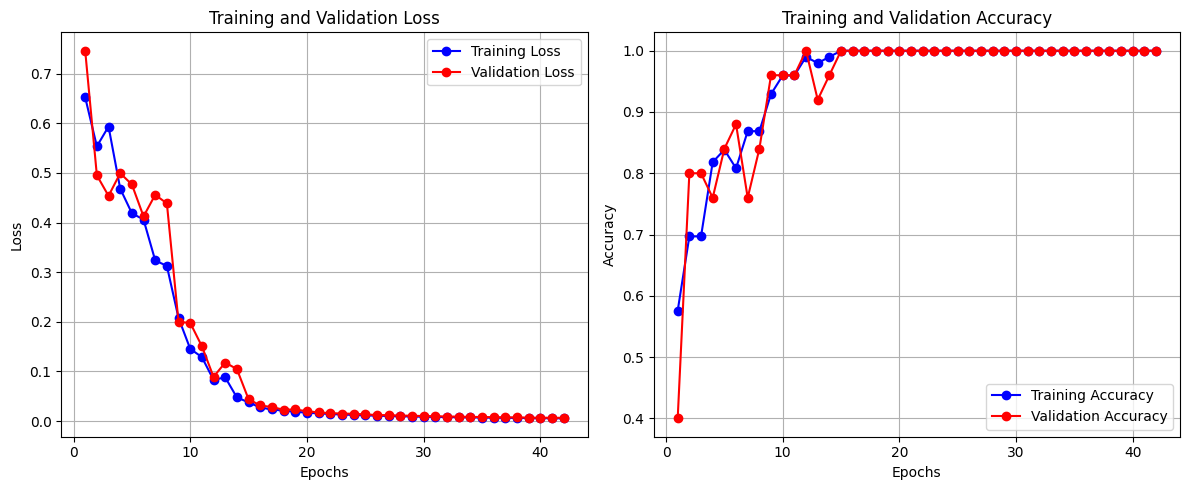

{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8000000000000003, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9919999957084655


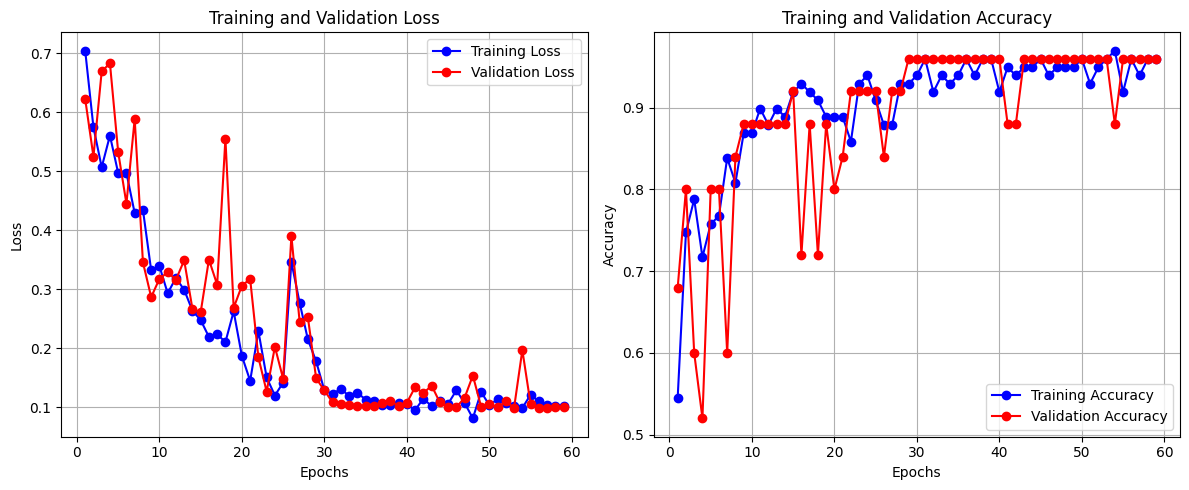

{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6000000000000001, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9919999957084655


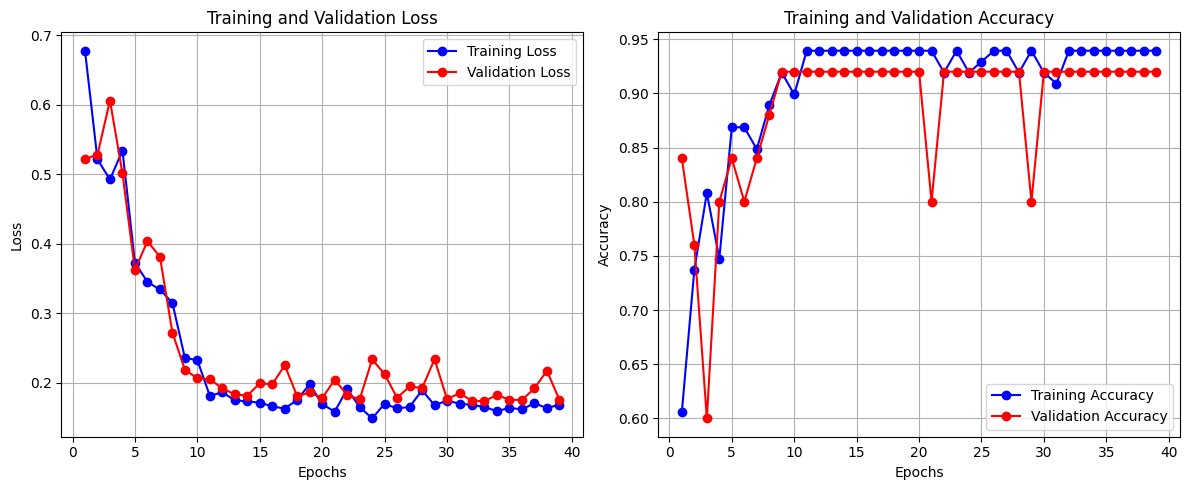

{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9919999957084655


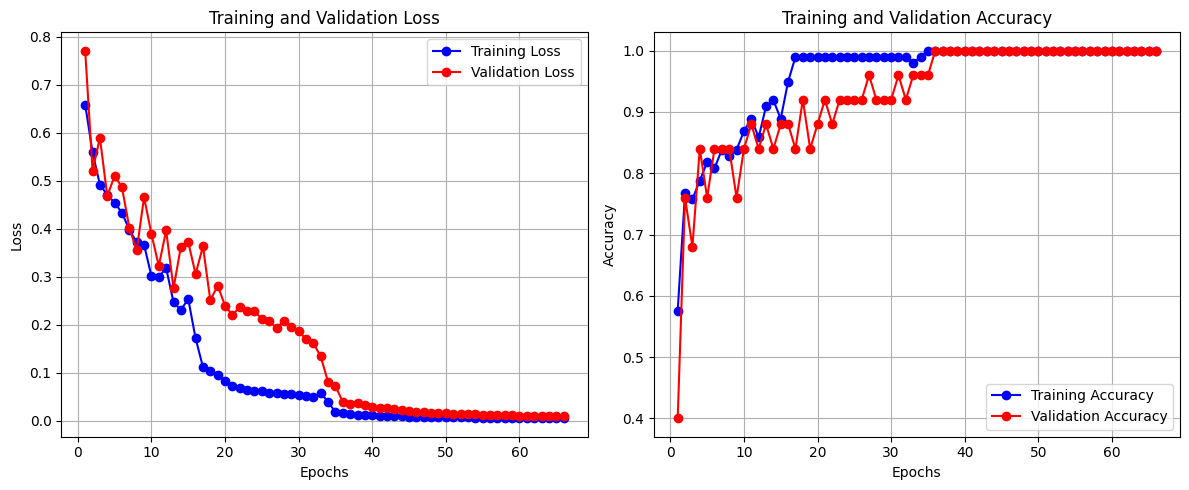

{'learning_rate': 0.7, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7000000000000002, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9839999914169312


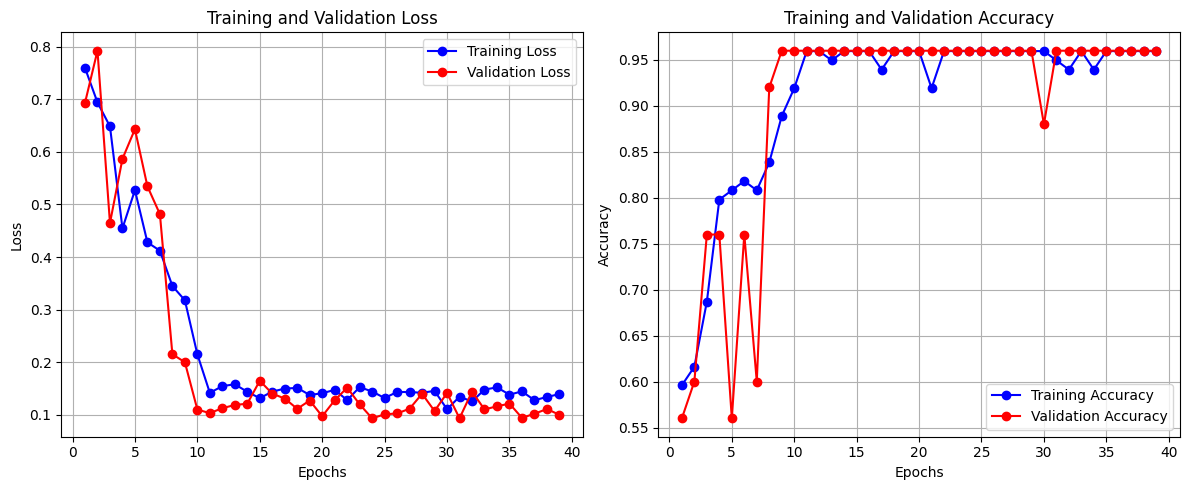

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6000000000000001, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9836666584014893


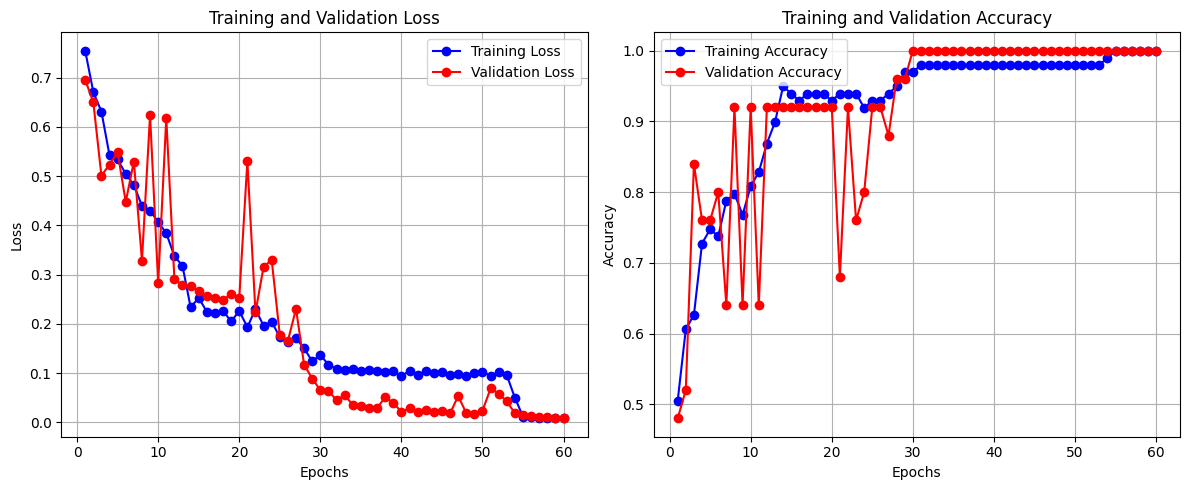

{'learning_rate': 0.5, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9759999871253967


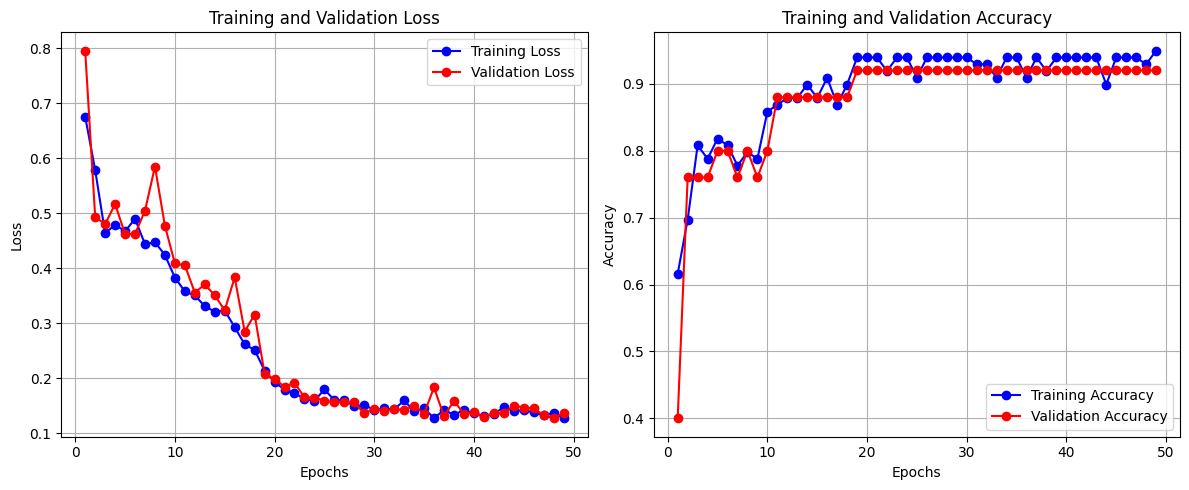

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.975


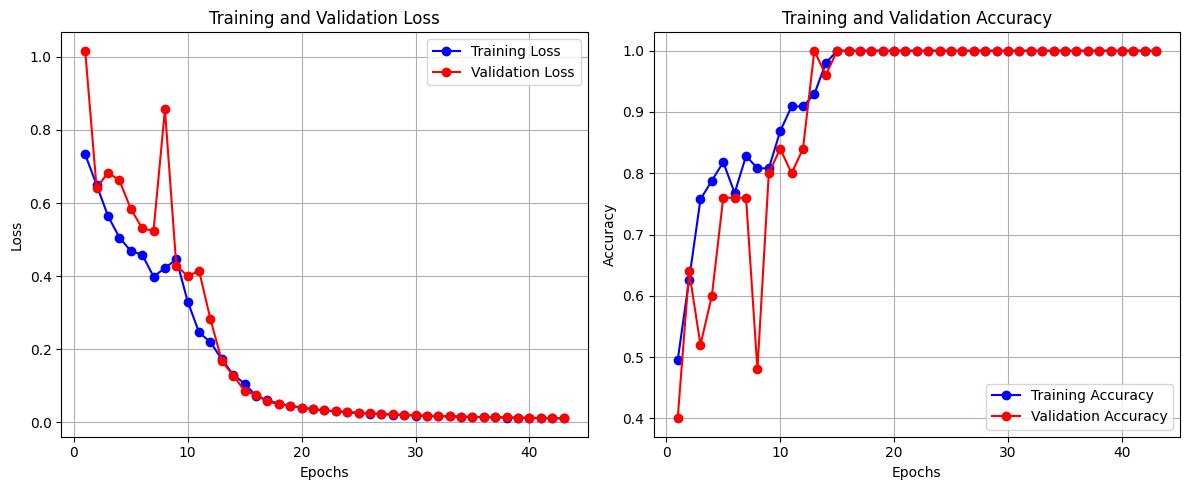

{'learning_rate': 0.7, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9676666617393493


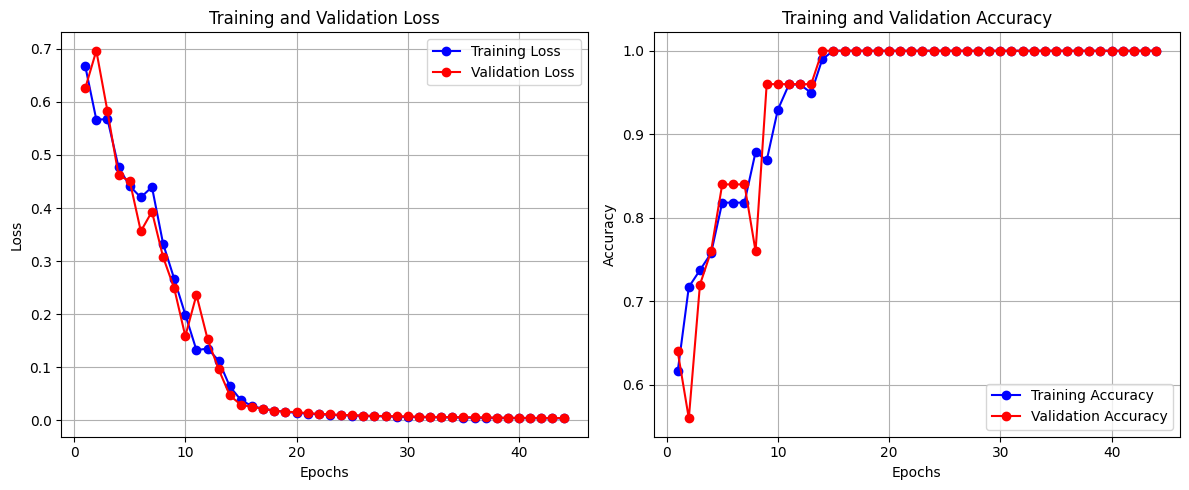

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9676666617393493


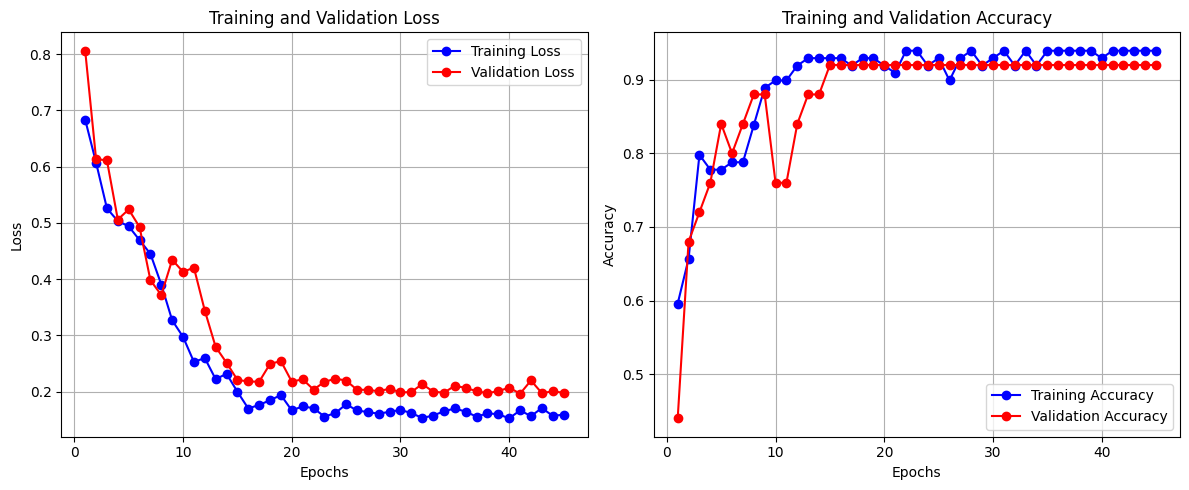

In [89]:
input_size = X1_train_encoded.shape[1]
output_size = 1

# Definizione dei range degli iperparametri
param_ranges_1 = {
    "learning_rate": (0.4, 0.7, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (180, 180, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 4, 1),             # Da 8 a 32 con step di 8
    "hidden_size": (3, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.3, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.001, 0.001, 0.005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

param_grid_monk1 = []
param_grid_monk1 = generate_hyperparameter_combinations(param_ranges_1)



print("--------------------------------------------------MONK 1--------------------------------------------------")
best_scores[0], best_params_list[0], best_models[0], best_histories[0] = greed_search(X1_train_encoded, y1_train, 
                                                                                      'tanh', 'SGD', False, 
                                                                                      input_size, param_grid_monk1)

print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories[0], best_params_list[0], best_scores[0])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)

In [ ]:
input_size = X2_train_encoded.shape[1]
output_size = 1

# Definizione dei range degli iperparametri
param_ranges_2 = {
    "learning_rate": (0.4, 0.9, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (180, 180, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 16, 6),             # Da 8 a 32 con step di 8
    "hidden_size": (3, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.3, 0.6, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.001, 0.001, 0.005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

param_grid_monk2 = []
param_grid_monk2 = generate_hyperparameter_combinations(param_ranges_2)



print("--------------------------------------------------MONK 2--------------------------------------------------")
best_scores[1], best_params_list[1], best_models[1], best_histories[1] = greed_search(X2_train_encoded, y2_train,
                                                                                      'tanh', 'SGD', False, 
                                                                                       input_size, param_grid_monk2)

print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories[1], best_params_list[1], best_scores[1])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)

--------------------------------------------------MONK 2--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9529411792755127
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9882352948188782
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 1.0
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidde

--------------------------------------------------MONK 3--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.9, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.9, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9023333191871643
--------------------END GREED SEARCH------------------------------
--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.9, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.9, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9023333191871643


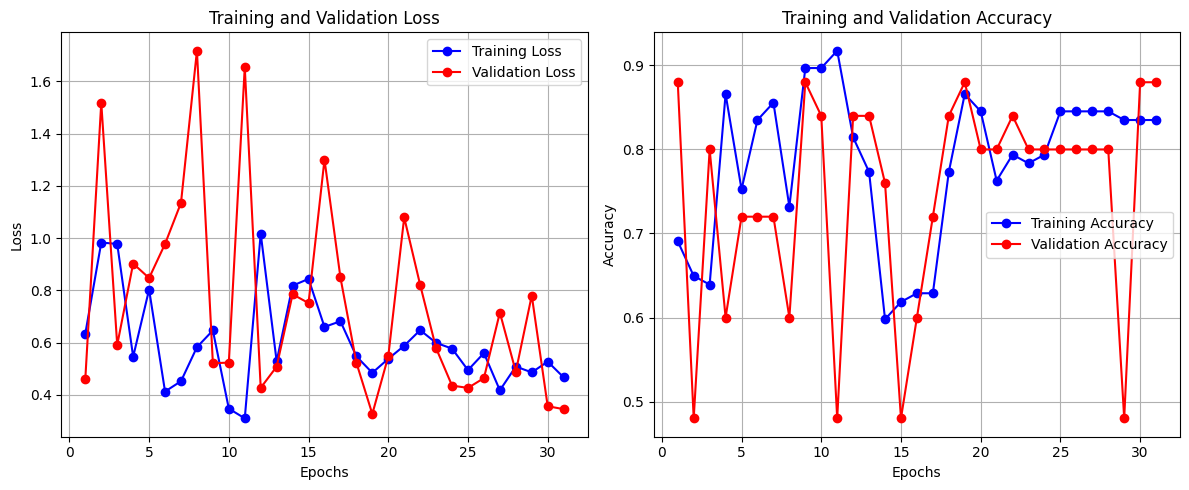

In [ ]:
input_size = X3_train_encoded.shape[1]
output_size = 1

# Definizione dei range degli iperparametri
param_ranges_3 = {
    "learning_rate": (0.1, 0.4, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (180, 180, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 16, 6),             # Da 8 a 32 con step di 8
    "hidden_size": (2, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.3, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.1, 0.4, 0.2),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

param_grid_monk3 = []
param_grid_monk3 = generate_hyperparameter_combinations(param_ranges_3)

print("--------------------------------------------------MONK 3--------------------------------------------------")
best_scores[2], best_params_list[2], best_models[2], best_histories[2] = param_grid = greed_search(X3_train_encoded, y3_train,
                                                                                                   'tanh', 'SGD', True, 
                                                                                                   input_size, param_grid_monk3)

print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories[2], best_params_list[2], best_scores[2])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)

## Model assessment

In [ ]:
best_models[0][0].evaluate(X1_test_encoded, y1_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6604 - auc: 0.6791 - loss: 0.9489 


[0.6805810332298279, 0.7662037014961243, 0.7841005921363831]

**best paramters found at the moment (Adam, regularized, relu)**  
{'learning_rate': 0.6, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}  


**best paramters found at the moment (SGD, regularized, tanh)**  
**1**  
{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**2**  
{'learning_rate': 0.7, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6000000000000001, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**3**:  
{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**7**  
{'learning_rate': 0.5, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**8**  
{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
